<a href="https://colab.research.google.com/github/Vik7am10/NBADecisionTree/blob/main/NBAPlayerClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nathanlauga/nba-games")

print("Path to dataset files:", path)

100%|██████████| 21.2M/21.2M [00:00<00:00, 77.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nathanlauga/nba-games/versions/10


In [2]:
import pandas as pd

# Load datasets
games = pd.read_csv(f"{path}/games.csv")
games_details = pd.read_csv(f"{path}/games_details.csv")
players = pd.read_csv(f"{path}/players.csv")
teams = pd.read_csv(f"{path}/teams.csv")
ranking = pd.read_csv(f"{path}/ranking.csv")

# Explore the structure of each dataset
print("Games Dataset:")
print(games.head())

print("\nGames Details Dataset:")
print(games_details.head())

print("\nPlayers Dataset:")
print(players.head())

print("\nTeams Dataset:")
print(teams.head())

print("\nRanking Dataset:")
print(ranking.head())


<ipython-input-2-2759d2b1aa92>:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details = pd.read_csv(f"{path}/games_details.csv")


Games Dataset:
  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final    1610612740       1610612759   
1    2022-12-22  22200478            Final    1610612762       1610612764   
2    2022-12-21  22200466            Final    1610612739       1610612749   
3    2022-12-21  22200467            Final    1610612755       1610612765   
4    2022-12-21  22200468            Final    1610612737       1610612741   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2022    1610612740     126.0        0.484        0.926  ...      25.0   
1    2022    1610612762     120.0        0.488        0.952  ...      16.0   
2    2022    1610612739     114.0        0.482        0.786  ...      22.0   
3    2022    1610612755     113.0        0.441        0.909  ...      27.0   
4    2022    1610612737     108.0        0.429        1.000  ...      22.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_

In [ ]:
# List all columns in games_details
print("Columns in games_details:")
print(games_details.columns)

# Display column data types
print("\nData types of columns in games_details:")
print(games_details.dtypes)


Columns in games_details:
Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS',
       'PLUS_MINUS'],
      dtype='object')

Data types of columns in games_details:
GAME_ID                int64
TEAM_ID                int64
TEAM_ABBREVIATION     object
TEAM_CITY             object
PLAYER_ID              int64
PLAYER_NAME           object
NICKNAME              object
START_POSITION        object
COMMENT               object
MIN                   object
FGM                  float64
FGA                  float64
FG_PCT               float64
FG3M                 float64
FG3A                 float64
FG3_PCT              float64
FTM                  float64
FTA                  float64
FT_PCT               float64
OREB                 float64
DREB       

In [3]:
# Check the first few PLAYER_IDs in both datasets
print("PLAYER_IDs in games_details:")
print(games_details['PLAYER_ID'].unique()[:5])

print("\nPLAYER_IDs in players:")
print(players['PLAYER_ID'].unique()[:5])

# Check if there are mismatches
missing_ids = set(games_details['PLAYER_ID']).difference(players['PLAYER_ID'])
print(f"\nPLAYER_IDs in games_details but not in players: {len(missing_ids)}")


PLAYER_IDs in games_details:
[1629641 1631110 1627751 1630170 1630200]

PLAYER_IDs in players:
[1626220  202711  203497 1628378  201144]

PLAYER_IDs in games_details but not in players: 918


In [4]:
print("Sample of converted minutes:")
print(games_details[['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'MIN']].head())

Sample of converted minutes:
    GAME_ID     TEAM_ID  PLAYER_ID    MIN
0  22200477  1610612759    1629641  18:06
1  22200477  1610612759    1631110  31:01
2  22200477  1610612759    1627751  21:42
3  22200477  1610612759    1630170  30:20
4  22200477  1610612759    1630200  27:44


In [5]:
# Convert 'MIN' from MM:SS format to total minutes as a float
def convert_min_to_float(min_str):
    try:
        # Check if the value is a string in MM:SS format
        if isinstance(min_str, str) and ':' in min_str:
            mins, secs = map(int, min_str.split(':'))
            return mins + secs / 60
        # If it's already numeric, return it as is
        elif isinstance(min_str, (int, float)):
            return float(min_str)
    except:
        # Return 0.0 for any invalid or malformed entry
        return 0.0

# Apply conversion to the 'MIN' column
games_details['MIN'] = games_details['MIN'].apply(convert_min_to_float)

# Verify the conversion
print("Sample of converted MIN column:")
print(games_details[['GAME_ID', 'PLAYER_ID', 'MIN']].head())


Sample of converted MIN column:
    GAME_ID  PLAYER_ID        MIN
0  22200477    1629641  18.100000
1  22200477    1631110  31.016667
2  22200477    1627751  21.700000
3  22200477    1630170  30.333333
4  22200477    1630200  27.733333


In [6]:
# Replace NaN or negative values with 0.0
games_details['MIN'] = games_details['MIN'].fillna(0.0)
games_details['MIN'] = games_details['MIN'].clip(lower=0.0)

# Verify the cleaned MIN column
print("Cleaned MIN column:")
print(games_details[['GAME_ID', 'PLAYER_ID', 'MIN']].head())


Cleaned MIN column:
    GAME_ID  PLAYER_ID        MIN
0  22200477    1629641  18.100000
1  22200477    1631110  31.016667
2  22200477    1627751  21.700000
3  22200477    1630170  30.333333
4  22200477    1630200  27.733333


In [7]:
# Group by GAME_ID and TEAM_ID, then sort by MIN within each group
games_details_sorted = (
    games_details.groupby(['GAME_ID', 'TEAM_ID'], group_keys=False)  # Prevent hierarchical index
    .apply(lambda x: x.sort_values(by='MIN', ascending=False))  # Sort within each group
)

# Verify the sorting
print("Sample of sorted data within each GAME_ID and TEAM_ID:")
print(games_details_sorted[['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'MIN']].head(20))


Sample of sorted data within each GAME_ID and TEAM_ID:
         GAME_ID     TEAM_ID  PLAYER_ID  MIN
306910  10300001  1610612742       1712  0.0
306911  10300001  1610612742       1504  0.0
306912  10300001  1610612742       1717  0.0
306913  10300001  1610612742       2059  0.0
306914  10300001  1610612742       2412  0.0
306915  10300001  1610612742       2572  0.0
306916  10300001  1610612742       1711  0.0
306917  10300001  1610612742        762  0.0
306918  10300001  1610612742        959  0.0
306919  10300001  1610612742       1505  0.0
306920  10300001  1610612742        696  0.0
306891  10300001  1610612762       2144  0.0
306901  10300001  1610612762       1721  0.0
306908  10300001  1610612762       2221  0.0
306907  10300001  1610612762       1952  0.0
306906  10300001  1610612762       1514  0.0
306905  10300001  1610612762       2590  0.0
306904  10300001  1610612762       1913  0.0
306903  10300001  1610612762       1723  0.0
306902  10300001  1610612762       2068  0.0


<ipython-input-7-3c7fc06e37b3>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values(by='MIN', ascending=False))  # Sort within each group


In [8]:
print(games_details.head())  # Show the first few rows of the DataFrame
print(games_details.info())  # Display column names, data types, and non-null counts
# Merge games_details with games on GAME_ID to get the SEASON column
games_details = games_details.merge(games[['GAME_ID', 'SEASON']], on='GAME_ID', how='left')

# Check the updated games_details dataset
print(games_details.head())


    GAME_ID     TEAM_ID TEAM_ABBREVIATION    TEAM_CITY  PLAYER_ID  \
0  22200477  1610612759               SAS  San Antonio    1629641   
1  22200477  1610612759               SAS  San Antonio    1631110   
2  22200477  1610612759               SAS  San Antonio    1627751   
3  22200477  1610612759               SAS  San Antonio    1630170   
4  22200477  1610612759               SAS  San Antonio    1630200   

      PLAYER_NAME NICKNAME START_POSITION COMMENT        MIN  ...  OREB  DREB  \
0  Romeo Langford    Romeo              F     NaN  18.100000  ...   1.0   1.0   
1   Jeremy Sochan   Jeremy              F     NaN  31.016667  ...   6.0   3.0   
2    Jakob Poeltl    Jakob              C     NaN  21.700000  ...   1.0   3.0   
3   Devin Vassell    Devin              G     NaN  30.333333  ...   0.0   9.0   
4       Tre Jones      Tre              G     NaN  27.733333  ...   0.0   2.0   

   REB  AST  STL  BLK   TO   PF   PTS  PLUS_MINUS  
0  2.0  0.0  1.0  0.0  2.0  5.0   2.0        -

In [9]:
# Group by PLAYER_ID and SEASON to compute average stats across all games in a season
player_stats = games_details.groupby(['PLAYER_ID', 'SEASON']).agg({
    'PTS': 'mean',
    'AST': 'mean',
    'REB': 'mean',
    'STL': 'mean',
    'BLK': 'mean',
    'TO': 'mean',
    'OREB': 'mean',
    'DREB': 'mean',
    'PLUS_MINUS': 'mean',
    'FGM': 'mean',
    'FGA': 'mean',
    'FG_PCT': 'mean',
    'FG3M': 'mean',
    'FG3A': 'mean',
    'FG3_PCT': 'mean',
    'FTM': 'mean',
    'FTA': 'mean',
    'FT_PCT': 'mean',
    'MIN': 'mean'
}).reset_index()

# Add player names for interpretability (optional)
player_stats = player_stats.merge(players[['PLAYER_ID', 'PLAYER_NAME']], on='PLAYER_ID', how='left')

# Display the result
print(player_stats.head())

#Now we have each player per season averages




   PLAYER_ID  SEASON       PTS       AST       REB       STL       BLK  \
0         15    2003  4.196078  0.509804  1.490196  0.313725  0.098039   
1         15    2004  4.750000  0.750000  1.184211  0.500000  0.039474   
2         15    2005  2.230769  0.435897  0.897436  0.179487  0.051282   
3         15    2006  2.071429  0.357143  0.714286  0.000000  0.142857   
4         15    2007  2.473684  0.526316  0.789474  0.000000  0.052632   

         TO      OREB      DREB  ...       FGA    FG_PCT      FG3M      FG3A  \
0  0.588235  0.215686  1.274510  ...  3.941176  0.345784  0.882353  2.529412   
1  0.526316  0.210526  0.973684  ...  3.802632  0.356566  0.868421  2.026316   
2  0.358974  0.205128  0.692308  ...  2.102564  0.283128  0.358974  1.179487   
3  0.357143  0.142857  0.571429  ...  1.857143  0.281714  0.500000  1.285714   
4  0.421053  0.105263  0.684211  ...  2.105263  0.313158  0.684211  1.578947   

    FG3_PCT       FTM       FTA    FT_PCT       MIN  PLAYER_NAME  
0  0.30

In [19]:
from scipy.stats import zscore

# Columns to standardize
numeric_columns = [
    'PTS', 'AST', 'REB', 'STL', 'BLK', 'TO', 'OREB', 'DREB', 'PLUS_MINUS',
    'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'MIN'
]

# Standardize numeric columns using z-scores
player_stats_standardized = player_stats.copy()
player_stats_standardized[numeric_columns] = player_stats[numeric_columns].apply(zscore)

# Drop the column named 'cluster'
player_stats_standardized = player_stats_standardized.drop(columns=['Cluster'], errors='ignore')

# Display the result to confirm
print(player_stats_standardized.head())



     PLAYER_ID  SEASON       PTS       AST       REB       STL       BLK  \
96         255    2004  1.648630  0.609019  0.315630  1.709556 -0.086202   
97         255    2004  1.648630  0.609019  0.315630  1.709556 -0.086202   
98         255    2004  1.648630  0.609019  0.315630  1.709556 -0.086202   
99         255    2004  1.648630  0.609019  0.315630  1.709556 -0.086202   
100        255    2005  0.775969 -0.022729 -0.168921  0.974369 -0.361511   

           TO      OREB      DREB  ...    FG_PCT      FG3M      FG3A  \
96   1.289771  0.182818  0.349802  ...  0.986422 -0.939909 -0.978449   
97   1.289771  0.182818  0.349802  ...  0.986422 -0.939909 -0.978449   
98   1.289771  0.182818  0.349802  ...  0.986422 -0.939909 -0.978449   
99   1.289771  0.182818  0.349802  ...  0.986422 -0.939909 -0.978449   
100  0.612567 -0.365381 -0.066012  ...  0.413608 -0.839757 -0.899765   

      FG3_PCT       FTM       FTA    FT_PCT       MIN  PLAYER_NAME  Cluster  
96  -1.172585  1.637948  1.52201

Classification starts here


PCA reduced to 6 components.


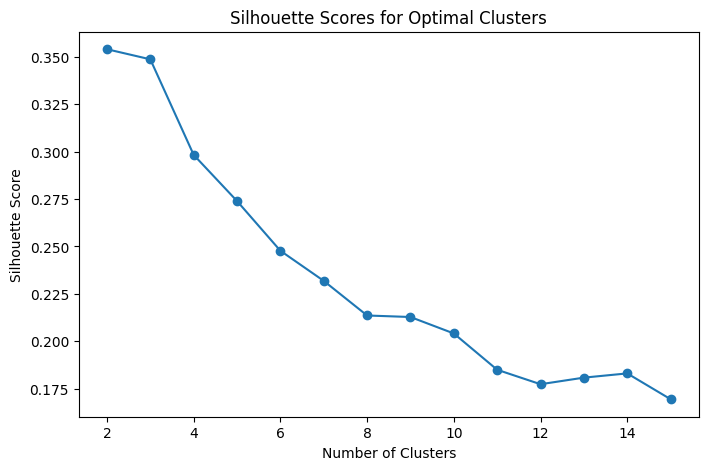

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


# Drop rows with NaN values
player_stats_cleaned = player_stats_standardized.dropna()

# Select numeric columns for clustering
numeric_columns = [
    'PTS', 'AST', 'REB', 'STL', 'BLK', 'TO', 'OREB', 'DREB', 'PLUS_MINUS',
    'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'MIN'
]
data_for_clustering = player_stats_cleaned[numeric_columns]

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# Apply PCA to retain 88% variance
pca = PCA(n_components=0.88)  # Retain 88% variance
data_pca = pca.fit_transform(data_scaled)
print(f"PCA reduced to {data_pca.shape[1]} components.")

silhouette_scores = []
cluster_range = range(2, 16)  # Test 2 to 15 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [23]:
# Perform K-Means clustering with an optimal number of clusters (e.g., k=10 based on silhouette curve)
optimal_clusters = 10  # Adjust based on the elbow curve
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
player_stats_cleaned['Cluster'] = kmeans.fit_predict(data_pca)

# Display the clustered data
print(player_stats_cleaned.head())

     PLAYER_ID  SEASON       PTS       AST       REB       STL       BLK  \
96         255    2004  1.648630  0.609019  0.315630  1.709556 -0.086202   
97         255    2004  1.648630  0.609019  0.315630  1.709556 -0.086202   
98         255    2004  1.648630  0.609019  0.315630  1.709556 -0.086202   
99         255    2004  1.648630  0.609019  0.315630  1.709556 -0.086202   
100        255    2005  0.775969 -0.022729 -0.168921  0.974369 -0.361511   

           TO      OREB      DREB  ...    FG_PCT      FG3M      FG3A  \
96   1.289771  0.182818  0.349802  ...  0.986422 -0.939909 -0.978449   
97   1.289771  0.182818  0.349802  ...  0.986422 -0.939909 -0.978449   
98   1.289771  0.182818  0.349802  ...  0.986422 -0.939909 -0.978449   
99   1.289771  0.182818  0.349802  ...  0.986422 -0.939909 -0.978449   
100  0.612567 -0.365381 -0.066012  ...  0.413608 -0.839757 -0.899765   

      FG3_PCT       FTM       FTA    FT_PCT       MIN  PLAYER_NAME  Cluster  
96  -1.172585  1.637948  1.52201

In [24]:
output_file = "player_stats_with_clusters.csv"
player_stats_cleaned.to_csv(output_file, index=False)